# 准备工作

import package

In [1]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l
import os
from collections import Counter
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

# 获取数据集

数据集使用的是大佬李沐在kaggle上组织的[California House Prices](https://www.kaggle.com/competitions/california-house-prices)比赛。  
根据房屋信息预测房屋销售价格，例如#卧室，居住区，位置，附近学校和卖方摘要。该数据包括 2020 年在加利福尼亚州出售的房屋，测试数据集中的房屋在训练数据集中的房屋之后的时间出售。此外，私人排行榜上的房子在公共排行榜上的房子之后被出售。

数据集下载地址：https://www.kaggle.com/competitions/26688/download-all

# 数据集概述

解压后数据集的目录结构如下  
* sample_submission.csv：提交预测结果的示例文件  
* test.csv：测试集数据  
* train.csv：训练集数据

> └─sample_submission.csv  
> └─test.csv  
> └─train.csv

# 预览数据集

定义训练数据、测试数据的路径

In [2]:
train_path = '../data/california-house-prices/train.csv'
test_path = '../data/california-house-prices/test.csv'

预览train.csv

In [3]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
train_data.head()

,Id,Address,Sold Price,Summary,Type,Year built,Heating,Cooling,Parking,Lot,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan","Garage, Garage - Attached, Covered",1.0,...,"Garage, Garage - Attached, Covered",886486.0,12580.0,2019-10-24,4198000.0,NaN,NaN,Los Altos,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...","Detached Carport, Garage",4047.0,...,"Detached Carport, Garage",505000.0,6253.0,2019-10-16,525000.0,2019-08-30,328000.0,Los Angeles,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,0 spaces,9147.0,...,NaN,49627.0,468.0,2019-08-25,180000.0,NaN,NaN,Strawberry,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,"Detached Carport, Driveway, Garage - Two Door",NaN,...,"Detached Carport, Driveway, Garage - Two Door",1775000.0,20787.0,2019-10-24,1895000.0,2016-08-30,1500000.0,Culver City,90230,CA
4,4,7415 O Donovan Rd,1175000.0,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,0 spaces,NaN,...,NaN,NaN,NaN,2019-06-07,1595000.0,2016-06-27,900000.0,Creston,93432,CA


In [4]:
len(train_data)

47439

* 训练数据中第一列是id，id不能参与训练，否则就是直接记住样本，这里需要删除
* 训练数据中有大量的文字描述需要处理(这里采用简单粗暴的方式，直接删除)
* 训练数据中有数量级大的数字特征需要处理(这里采用取log的方式)
* 训练数据中有日期的特征需要处理(这里采用简单粗暴的方式，直接删除)
* 训练数据中的Parking、Bedrooms是用文字描述逗号隔开的特征，这里将其转换为该特征的数量，也就是(逗号数量)+1
* 总共有47439个训练样本，采用K值交叉验证的方式进行训练

# 定义训练使用到的工具方法

转换文字描述逗号隔开的特征为特征数量

In [5]:
def clean_currency(x):
    try:
        x = float(x)
    except:
        x = x.count(',') + 1
    return(x)

定义获取单个gpu设备的方法

In [6]:
def try_gpu(i=0):  #@save
    """如果存在，则返回gpu(i)，否则返回cpu()"""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

定义获取所有gpu设备的方法

In [7]:
def try_all_gpus():  #@save
    """返回所有可用的GPU，如果没有GPU，则返回[cpu(),]"""
    devices = [torch.device(f'cuda:{i}')
             for i in range(torch.cuda.device_count())]
    return devices if devices else [torch.device('cpu')]

测试获取gpu设备的方法

In [8]:
try_gpu(), try_gpu(10), try_all_gpus()

(device(type='cuda', index=0),
 device(type='cpu'),
 [device(type='cuda', index=0)])

# 处理数据

将train_data中的SoldPrice(售价)移动到最后一列

In [9]:
last_column = train_data.pop('Sold Price')
train_data.insert(40, 'SoldPrice', last_column)

拼接train_data和test_data
* train_data 过滤Id列和SoldPrice列
* test_data 过滤Id列

In [10]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [11]:
all_features.shape

(79065, 39)

处理Parking、Bedrooms，文字描述转换为：(文字描述中`逗号数量`)+1

In [12]:
field_list = ['Parking', 'Bedrooms']
for c in field_list:
    all_features[c] = all_features[c].apply(clean_currency).astype('float')

处理数量级大的数字特征,取log

In [13]:
large_vel_cols = ['Lot', 'Total interior livable area', 'Tax assessed value',
                  'Annual tax amount', 'Listed Price', 'Last Sold Price']
for c in large_vel_cols:
    all_features[c] = np.log(all_features[c] + 1)

In [14]:
all_features.head()

,Address,Summary,Type,Year built,Heating,Cooling,Parking,Lot,Bedrooms,Bathrooms,...,Parking features,Tax assessed value,Annual tax amount,Listed On,Listed Price,Last Sold On,Last Sold Price,City,Zip,State
0,540 Pine Ln,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,1969.0,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan",3.0,0.693147,4.0,0.0,...,"Garage, Garage - Attached, Covered",13.695022,9.439943,2019-10-24,15.250119,NaN,NaN,Los Altos,94022,CA
1,1727 W 67th St,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,1926.0,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",2.0,8.305978,3.0,2.0,...,"Detached Carport, Garage",13.132316,8.740977,2019-10-16,13.171155,2019-08-30,12.700772,Los Angeles,90047,CA
2,28093 Pine Ave,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,1958.0,Forced air,NaN,1.0,9.121291,2.0,3.0,...,NaN,10.812310,6.150603,2019-08-25,12.100718,NaN,NaN,Strawberry,95375,CA
3,10750 Braddock Dr,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,1947.0,Central,Central Air,3.0,NaN,5.0,3.0,...,"Detached Carport, Driveway, Garage - Two Door",14.389312,9.942131,2019-10-24,14.454730,2016-08-30,14.220976,Culver City,90230,CA
4,7415 O Donovan Rd,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,2019-06-07,14.282385,2016-06-27,13.710151,Creston,93432,CA


均值化处理数字类型的特征

In [15]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x : (x - x.mean()) / (x.std()))

数字特征空值处理

In [16]:
all_features[numeric_features] = all_features[numeric_features].fillna(0)

查看非数字特征

In [17]:
other_features = all_features.dtypes[all_features.dtypes == 'object'].index
all_features[other_features].head()

,Address,Summary,Type,Heating,Cooling,Region,Elementary School,Middle School,High School,Flooring,Heating features,Cooling features,Appliances included,Laundry features,Parking features,Listed On,Last Sold On,City,State
0,540 Pine Ln,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,"Heating - 2+ Zones, Central Forced Air - Gas","Multi-Zone, Central AC, Whole House / Attic Fan",Los Altos,Santa Rita Elementary School,NaN,Los Altos High School,"Tile, Hardwood, Carpet","Forced air, Gas",Central,"Dishwasher, Dryer, Garbage disposal, Microwave...","Washer / Dryer, Inside, In Utility Room","Garage, Garage - Attached, Covered",2019-10-24,NaN,Los Altos,CA
1,1727 W 67th St,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",Los Angeles,Raymond Avenue Elementary School,John Muir Middle School,Augustus F. Hawkins High A Critical Design And...,NaN,Combination,"Wall/Window Unit(s), Evaporative Cooling, See ...",NaN,Inside,"Detached Carport, Garage",2019-10-16,2019-08-30,Los Angeles,CA
2,28093 Pine Ave,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,Forced air,NaN,Strawberry,NaN,NaN,Long Barn High School,NaN,Forced air,NaN,NaN,NaN,NaN,2019-08-25,NaN,Strawberry,CA
3,10750 Braddock Dr,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,Central,Central Air,Culver City,Farragut Elementary School,Culver City Middle School,Culver City High School,"Wood, Tile",Central,Central Air,Dishwasher,"Stackable, Upper Level","Detached Carport, Driveway, Garage - Two Door",2019-10-24,2016-08-30,Culver City,CA
4,7415 O Donovan Rd,Beautiful 200 acre ranch land with several pas...,VacantLand,NaN,NaN,Creston,Santa Margarita Elementary School,Atascadero Middle School,Atascadero High School,NaN,NaN,NaN,NaN,NaN,NaN,2019-06-07,2016-06-27,Creston,CA


丢弃文本、日期特征

In [18]:
all_features = all_features.drop(labels=['Address', 'Summary', 'Heating', 'Cooling', 'Region',
       'Elementary School', 'Middle School', 'High School', 'Flooring',
       'Heating features', 'Cooling features', 'Appliances included',
       'Laundry features', 'Parking features', 'Listed On', 'Last Sold On',
       'City', 'State'], axis=1)

把离散的类别信息转化为onehot编码形式

In [19]:
all_features = pd.get_dummies(all_features, dummy_na=True)

In [20]:
all_features.shape

(79065, 195)

拆分训练集和测试集

In [21]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[0:n_train].values, dtype=torch.float32, device=try_gpu())
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32, device=try_gpu())
train_labels = torch.tensor(train_data.SoldPrice.values.reshape(-1, 1), dtype=torch.float32, device=try_gpu())

定义损失函数和网络

In [22]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Flatten(),
                        nn.Linear(in_features, 128),
                        nn.ReLU(),
                        nn.Linear(128, 1))
    net = net.to(device=try_gpu())
    return net

定义相对误差计算方法，计算房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量

In [23]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

定义训练方法

In [24]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

定义k值交叉验证方法

In [25]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [26]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

k值交叉验证训练，确定超参数

折1，训练log rmse0.580382, 验证log rmse0.501612
折2，训练log rmse0.484991, 验证log rmse0.489808
折3，训练log rmse0.517772, 验证log rmse0.534443
折4，训练log rmse0.521485, 验证log rmse0.495073
折5，训练log rmse0.456916, 验证log rmse0.495945
5-折验证: 平均训练log rmse: 0.512309, 平均验证log rmse: 0.503376


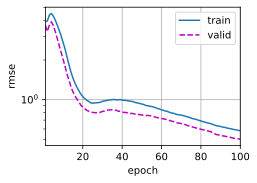

In [27]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 0.01, 512
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

定义整体数据集训练

In [28]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().cpu().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['Sold Price'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['Sold Price']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练和预测

训练log rmse：0.460400


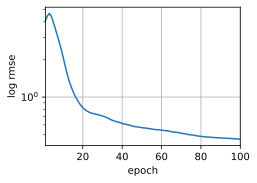

In [29]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)